# Analyse des déterminants de la réussite olympique

## Introduction

L’objectif de ce projet est d’analyser empiriquement l'impact des dépenses publiques en sport sur les performances des pays aux Jeux Olympiques d’été. La performance olympique est mesurée à l’aide d’un score agrégé construit à partir des médailles obtenues, permettant de comparer les résultats sportifs entre pays et au fil du temps.

La réussite olympique ne repose pas uniquement sur des facteurs sportifs intrinsèques, tels que le talent individuel ou les traditions sportives, mais dépend également de déterminants économiques, institutionnels et structurels. Le niveau de richesse, le degré de développement humain ou encore l’effort public consacré au sport sont susceptibles d’influencer la capacité des pays à former, sélectionner et accompagner des athlètes de haut niveau.

Une des motivations de ce sujet est la suivante : 

A première vue, la taille de la population semble un facteur essentiel des écarts de performance entre les pays aux Jeux Olympiques.
En effet, on peut penser que le niveau sportif des individus au sein d'une population est probabiliste et peut être modélisé par une certaine loi (par exemple, disons une loi à l'allure d'une gaussienne et à valeurs positives pour se fixer les idées) ; ainsi on pourrait établir un lien entre taille de la population et performances  olympiques, en considérant que le nombre de grands sportifs correspond au nombre d'occurence de valeurs extrêmes de cette loi. 
Dans le modèle gaussien que l'on prenait pour exemple, une population de grande taille  correspondrait à une loi du Khi2 avec un grand nombre de degrés de liberté, produisant des sportifs de très haut niveau et en quantité.

Pour différencier les pays entre eux et expliquer, par exemple, les mauvaises performances de l'Inde malgré son immenses population, on pourrait considérer que les dépenses publiques servent à redresser l'espérance de la gaussienne (infrastructures sportives, subventions de la pratique sportive, heures de sport à l'école), ou bien à rendre les valeurs extrêmement élevées plus probables (cursus scolaires aménagés pour les sportifs de haut niveau, clubs d'élite, etc.). Cette modélisation très simplifiée des performances sportives des individus nous incite à tenter de mieux saisir l'effet des politiques publiques sur le niveau sportif d'une population.

Dans ce contexte, ce projet vise à évaluer empiriquement le rôle de l'Etat à travers les dépenses publiques dans le domaine du sport, tout en étudiant les effets des autres déterminants, plus ou moins corrélés à la richesse du pays ou à sa taille. Il s’appuie sur la construction d’un jeu de données pays–année combinant plusieurs sources internationales, couvrant à la fois les performances sportives, les indicateurs économiques et les caractéristiques structurelles des pays.

L’analyse repose sur une approche progressive, mêlant visualisations descriptives et estimations économétriques simples. Les modèles estimés cherchent à mettre en évidence des associations conditionnelles entre performance sportive et variables explicatives, sans prétendre à une interprétation strictement causale. L’objectif est notamment de proposer une lecture empirique cohérente et structurée de l'impact des politiques publiques d'investissement dans le sport (infrastructures, clubs, éducation, etc.) 

## 1. Import des bibliothèques et des fonctions

Cette section importe l’ensemble des bibliothèques nécessaires à l’analyse (manipulation de données, visualisation, économétrie), ainsi que les fonctions définies dans les scripts du projet.

La logique de préparation des données est volontairement externalisée dans des fichiers Python dédiés afin de maintenir un notebook lisible et structuré.

In [ ]:
# Imports & configuration 

import sys
import importlib
import pandas as pd
import statsmodels.api as sm

# Chemin vers les scripts du projet
sys.path.append("../Scriptsfinal")

# Imports des modules du projet 
import medals
import pib_eu
import depenses
import Visu3
import Reg3
import merge_data
import Prepro3
import data_loading
import features
import Prepro_long3

# Reload (pour éviter les bugs inopinés)
importlib.reload(medals)
importlib.reload(pib_eu)
importlib.reload(depenses)
importlib.reload(Visu3)
importlib.reload(Reg3)
importlib.reload(merge_data)
importlib.reload(Prepro3)
importlib.reload(data_loading)
importlib.reload(features)
importlib.reload(Prepro_long3)

# Imports des fonctions utilisées 
from medals import process_medals
from pib_eu import process_pib_eu
from depenses import process_depenses
from idh import process_idh
from pib_world import process_pib_world
from merge_data import merge_all

from data_loading import clean_main_df, add_us_data
from features import add_previous_score, add_delegation_size

from Prepro3 import prepare_data_volume
from Prepro_long3 import prepare_data_long

from Visu3 import (
    plot_score_vs_spending,
    scatter_controls,
    plot_regression_results,
)

from Reg3 import (
    correlation_analysis,
    run_ols,
    train_test_validation,
    add_lagged_depenses,
    run_2sls,
)

/Users/roland/Desktop/ENSAE 2A/Python data/projet_python_roland_sacha/Notebookfinal/../Scriptsfinal/pib_world.py:24: SyntaxWarning: invalid escape sequence '\d'
  df_long['JO Year'] = df_long['JO Year'].str.extract('(\d+)$').astype(int)


## 2. Construction de la variable de performance olympique
La première étape consiste à construire une mesure synthétique de la réussite olympique.

À partir des données de médailles des Jeux Olympiques d’été, les médailles sont agrégées par pays et par édition.  
Un score est ensuite calculé en pondérant les médailles d’or, d’argent et de bronze, de manière à refléter l’intensité de la performance sportive.

Ce score constitue la variable dépendante principale de l’analyse.

In [3]:

df_all_games, df_score, df_athlete = process_medals()
df_score.head(10)

,Year,Team,Score
0,1896,Australia,10
1,1896,Australia/Great Britain,1
2,1896,Austria,14
3,1896,Denmark,12
4,1896,Ethnikos Gymnastikos Syllogos,1
5,1896,France,35
6,1896,Germany,42
7,1896,Great Britain,18
8,1896,Great Britain/Germany,5
9,1896,Greece,98


## 3. Variables explicatives économiques et structurelles

Cette section prépare les différentes variables explicatives utilisées dans l’analyse.

### 3.1 PIB par habitant

Le PIB par habitant est utilisé comme proxy du niveau de richesse d’un pays.  
Afin de limiter les problèmes d’endogénéité, on retient le PIB moyen observé sur les années précédant chaque édition des Jeux Olympiques.

Cette variable permet de capturer la capacité économique générale d’un pays à investir dans le sport de haut niveau.

In [4]:
df_PIB_long = process_pib_eu()
df_PIB_long.head(10)

/opt/homebrew/anaconda3/lib/python3.12/site-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: Données!$1:$1048576.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


,Team,Country Code,Year,PIB
0,Austria,AUT,2016,318.0072
1,Belgium,BEL,2016,381.1002
2,Spain,ESP,2016,1213.8740
3,Estonia,EST,2016,29.2015
4,Finland,FIN,2016,170.1131
5,France,FRA,2016,1987.5494
6,Ireland,IRL,2016,241.5633
7,Italy,ITA,2016,1690.5546
8,Lithuania,LTU,2016,61.5078
9,Austria,AUT,2021,359.7171


In [5]:
df_PIB_hab = process_pib_world()
df_PIB_hab.head(10)

,Country Name,Country Code,JO Year,PIB_mean
0,Aruba,ABW,2012,25778.051271
1,NaN,AFE,2012,1536.255359
2,Afghanistan,AFG,2012,500.275781
3,NaN,AFW,2012,1657.933736
4,Angola,AGO,2012,3863.241475
5,Albanie,ALB,2012,4331.752197
6,Andorre,AND,2012,45627.880286
7,Le monde arabe,ARB,2012,6012.220713
8,Émirats arabes unis,ARE,2012,45585.739560
9,Argentine,ARG,2012,10014.690007


### 3.2 Indice de Développement Humain (IDH)

L’Indice de Développement Humain (IDH) permet de prendre en compte des dimensions plus larges du développement, telles que l’éducation et la santé.

Les données d’IDH n’étant pas disponibles pour chaque année olympique, une correspondance est établie entre chaque édition des Jeux Olympiques et l’année d’IDH la plus proche disponible.

In [6]:
df_IDH = process_idh()
df_IDH.head(10)

,Country,Year_IDH,HDI,Year
0,Very high human development,1990,NaN,1996.0
1,Iceland,1990,0.841,1996.0
2,Norway,1990,0.856,1996.0
3,Switzerland,1990,0.858,1996.0
4,Denmark,1990,0.844,1996.0
5,Germany,1990,0.834,1996.0
6,Sweden,1990,0.818,1996.0
7,Australia,1990,0.867,1996.0
8,"Hong Kong, China (SAR)",1990,0.755,1996.0
9,Netherlands,1990,0.855,1996.0


### 3.3 Dépenses sportives publiques

Les dépenses sportives publiques sont utilisées pour mesurer l’effort institutionnel consacré au sport.

Deux approches sont retenues :
- les dépenses exprimées en pourcentage du PIB,
- les dépenses exprimées en volume, obtenues en combinant le pourcentage du PIB et le PIB du pays.

Cette distinction permet de séparer l’intensité relative de l’effort public de son ampleur économique.
Dans un premier temps, nous traitons les dépenses en pourcentage du PIB

In [7]:
df_depenses = process_depenses()
df_depenses.head(10)

,Country,Year,Dépenses
0,Germany,2015,2.0
1,Germany,2016,2.0
2,Germany,2017,2.0
3,Germany,2018,2.0
4,Germany,2019,2.0
5,Germany,2020,2.2
6,Germany,2021,2.0
7,Germany,2022,2.0
8,Germany,2023,2.0
9,Austria,2015,2.5


## 4. Fusion et harmonisation des données

Les différents jeux de données sont ensuite fusionnés au niveau pays–année.

Un travail important d’harmonisation des noms de pays est nécessaire afin de garantir la cohérence entre les différentes sources.  
Les observations présentant des valeurs manquantes sur les variables clés sont supprimées afin de travailler sur un échantillon homogène.

L’analyse se concentre sur les pays européens ainsi que les États-Unis, ce choix permettant de limiter l’hétérogénéité institutionnelle tout en conservant un échantillon pertinent pour l’étude.

In [8]:
df_merged_final2 = merge_all(df_score, df_PIB_hab, df_IDH, df_depenses)
df_merged_final2.head(10)

,Year,Country,Score,Country Code,PIB_mean,HDI,Dépenses
0,2016,Austria,1.0,AUT,48446.490194,0.919,2.5
1,2016,Belgium,16.0,BEL,45182.087207,0.933,2.7
2,2016,Bulgaria,4.0,BGR,7641.548332,0.824,2.0
3,2016,Denmark,29.0,DNK,58858.958276,0.943,3.6
4,2016,Estonia,1.0,EST,18795.636738,0.888,4.1
5,2016,Finland,1.0,FIN,47469.202591,0.938,3.1
6,2016,France,100.0,FRA,40845.809814,0.901,2.9
7,2016,Germany,115.0,DEU,45709.422975,0.948,2.0
8,2016,Greece,19.0,GRC,20663.286641,0.888,1.7
9,2016,Hungary,50.0,HUN,13456.266151,0.847,6.6


## 5. Construction des variables dynamiques

Afin de tenir compte de la persistance de la performance sportive dans le temps, une variable de score retardé est introduite.

Cette variable permet d’étudier dans quelle mesure la réussite passée d’un pays aux Jeux Olympiques constitue un déterminant de sa réussite future, indépendamment de ses caractéristiques économiques contemporaines.

In [9]:
df = clean_main_df(df_merged_final2)
df = add_us_data(df)
df = clean_main_df(df_merged_final2)
df = add_us_data(df)
df = add_previous_score(df, df_score)
df_Reg = add_delegation_size(df, df_athlete)
df_Reg.head(10)

,Year,Country,Score,Country Code,PIB_mean,HDI,Dépenses,score_précédent,taille_délégation
0,2016,Austria,1.0,AUT,48446.490194,0.919,2.5,11.666667,2.0
1,2016,Belgium,16.0,BEL,45182.087207,0.933,2.7,6.000000,21.0
4,2016,Estonia,1.0,EST,18795.636738,0.888,4.1,4.666667,4.0
5,2016,Finland,1.0,FIN,47469.202591,0.938,3.1,5.666667,1.0
6,2016,France,100.0,FRA,40845.809814,0.901,2.9,86.000000,93.0
9,2016,Hungary,50.0,HUN,13456.266151,0.847,6.6,45.333333,15.0
10,2016,Ireland,4.0,IRL,55905.258420,0.931,1.2,5.333333,3.0
11,2016,Italy,70.0,ITA,34306.075480,0.889,1.6,73.333333,69.0
12,2016,Lithuania,5.0,LTU,15160.169828,0.869,2.0,10.000000,7.0
14,2016,Norway,4.0,NOR,94551.605105,0.959,3.6,21.666667,19.0


## 6. Analyse descriptive et visualisation

Avant de procéder aux estimations économétriques, une analyse descriptive est menée afin d’illustrer les relations entre la performance olympique et certaines variables explicatives, en particulier les dépenses sportives.

Les graphiques présentés mettent en évidence des corrélations brutes entre les variables, sans prétendre établir de relation causale.  
Ils permettent néanmoins de motiver l’analyse économétrique qui suit.

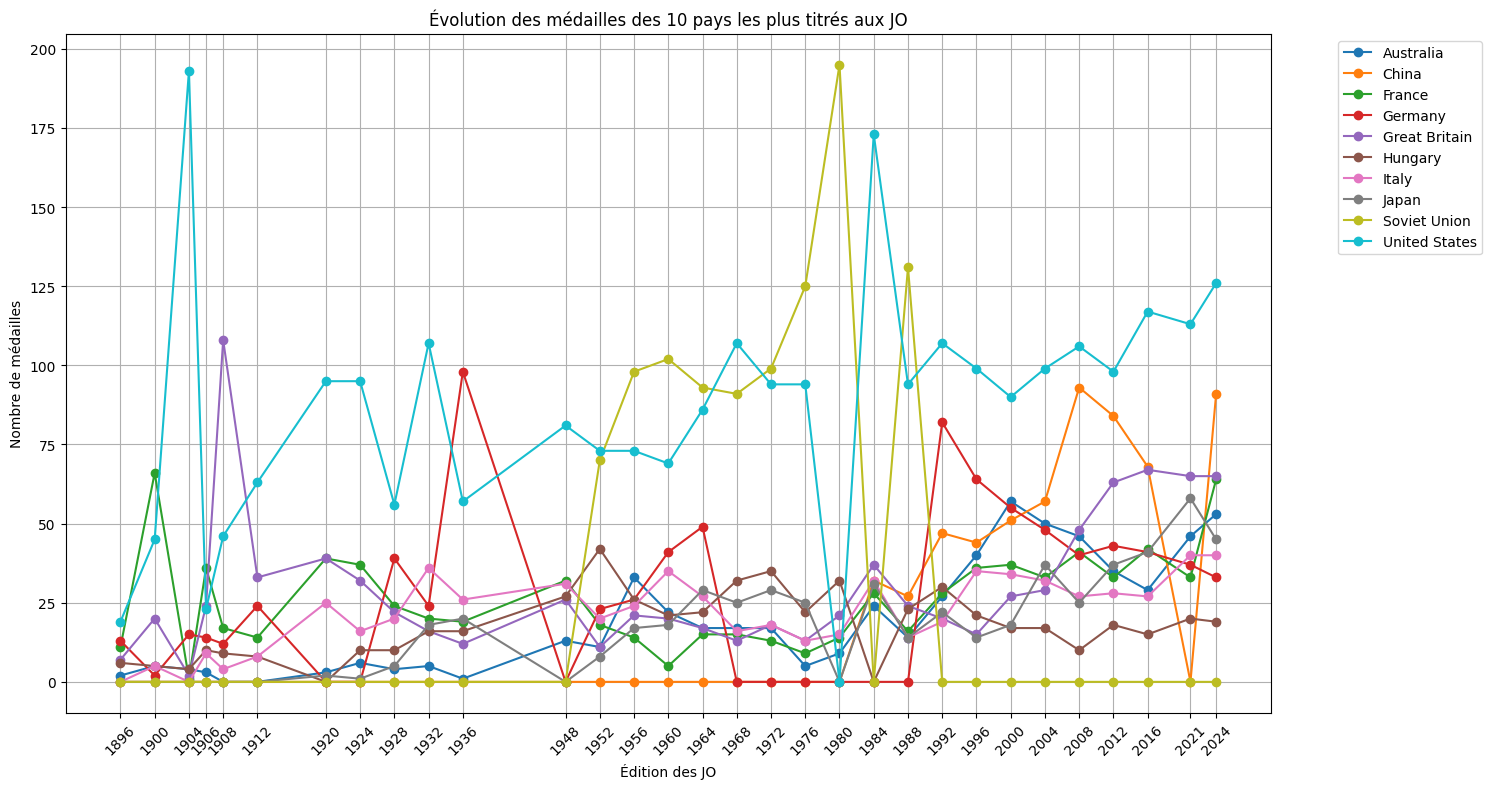

In [29]:
from Visu3 import plot_top_countries_medals
plot_top_countries_medals(df_all_games, top_n = 10) #top_n correspond au nombre de pays représentés en partant du meilleur


Ce graphique retrace l’évolution du nombre de médailles remportées par les dix pays les plus titrés aux Jeux Olympiques d’été depuis la fin du XIXᵉ siècle. Il met en évidence des trajectoires de performance très hétérogènes selon les pays et les périodes.

Plusieurs régularités ressortent. Tout d’abord, certains pays présentent une domination persistante sur longue période, en particulier les États-Unis, dont le niveau de médailles demeure élevé et relativement stable depuis l’après-guerre. Cette constance suggère l’existence d’avantages structurels durables, liés à la taille de la population, aux ressources économiques et à l’organisation du sport de haut niveau.

À l’inverse, d’autres pays connaissent des performances plus cycliques, marquées par des pics correspondant à des contextes historiques ou institutionnels spécifiques. Les fortes variations observées pour l’Union soviétique illustrent clairement cet effet, avec des performances élevées concentrées sur une période donnée, suivies d’une disparition brutale liée à des changements politiques majeurs.

Le graphique met également en évidence une montée progressive de certains pays européens (comme la France, l’Italie ou le Royaume-Uni) à partir de la seconde moitié du XXᵉ siècle, traduisant un renforcement des politiques sportives et une professionnalisation croissante des structures olympiques.

Cette visualisation présente toutefois plusieurs limites. D’une part, certains pays n’existent pas sur l’ensemble de la période considérée, ce qui rend les comparaisons de long terme délicates. Le cas de l’Union soviétique est emblématique : sa présence est limitée à une période spécifique, et ses performances ne sont pas directement comparables à celles de pays présents sur l’ensemble de l’échantillon. D’autre part, les changements de frontières, de dénominations nationales ou de périmètres institutionnels peuvent affecter la lecture des séries historiques.

Enfin, le graphique agrège des résultats bruts en nombre de médailles, sans tenir compte de la taille des délégations, du nombre d’épreuves disputées ou de la population des pays. Ces éléments, essentiels pour une analyse plus fine de la performance olympique, motivent le recours, dans la suite du projet, à des approches économétriques intégrant des variables explicatives et des contrôles appropriés.

Dans l’ensemble, cette analyse descriptive met en évidence le caractère cumulatif, institutionnel et historiquement situé de la réussite olympique, et justifie pleinement les choix méthodologiques retenus dans les sections suivantes.

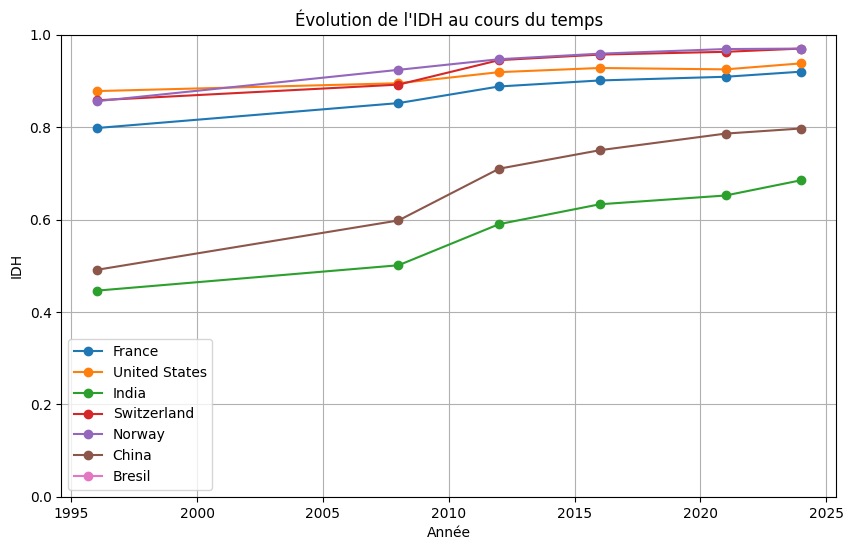

In [30]:

from Visu3 import plot_hdi_over_time
countries = ["France", "United States", "India", "Switzerland", "Norway", "China", "Bresil"]
plot_hdi_over_time(df_IDH, countries)

Ce graphique illustre l’évolution de l’indice de développement humain (IDH) pour un ensemble de pays représentatifs sur la période récente. Il met en évidence une amélioration générale du niveau de développement humain pour l’ensemble des pays considérés, bien que les trajectoires et les niveaux atteints restent hétérogènes.

Les pays développés (France, États-Unis, Suisse, Norvège) présentent des niveaux d’IDH élevés et relativement stables, avec une progression plus modérée au cours du temps. À l’inverse, les pays émergents (Chine, Inde, Brésil) connaissent des hausses plus marquées, traduisant un rattrapage progressif, sans pour autant atteindre les niveaux des pays les plus avancés.

Cette visualisation souligne ainsi que l’IDH constitue une variable pertinente pour capter des différences structurelles de développement entre pays, susceptibles d’influencer indirectement les performances sportives. Toutefois, l’amélioration de l’IDH ne se traduit pas mécaniquement par une réussite olympique accrue, ce qui justifie son utilisation comme variable de contrôle plutôt que comme déterminant unique.

## 7. Estimations économétriques

Les relations entre la performance olympique et les variables explicatives sont estimées à l’aide de modèles de régression linéaire (OLS).

Les spécifications sont introduites de manière progressive afin d’identifier le rôle respectif du niveau de richesse, du développement humain, des dépenses sportives et de la dynamique de performance.

Les coefficients estimés doivent être interprétés comme des associations conditionnelles et non comme des effets causaux stricts.

In [31]:
corr_simple, corr_hdi, corr_pib = correlation_analysis(df_Reg)
print(f"Corrélation simple entre Score et Dépenses (% PIB) : {corr_simple:.3f}")
print(f"Corrélation partielle Score-Dépenses contrôlant pour HDI : {corr_hdi:.3f}")
print(f"Corrélation partielle Score-Dépenses contrôlant pour PIB/hab : {corr_pib:.3f}")

Corrélation simple entre Score et Dépenses (% PIB) : -0.407
Corrélation partielle Score-Dépenses contrôlant pour HDI : -0.397
Corrélation partielle Score-Dépenses contrôlant pour PIB/hab : -0.355


### Interprétation des corrélations

Les résultats indiquent une corrélation négative entre le score olympique et les dépenses sportives exprimées en pourcentage du PIB.

La corrélation simple suggère que les pays consacrant une part plus élevée de leur PIB au sport ne sont pas nécessairement ceux qui obtiennent les meilleures performances olympiques. Cette relation négative persiste lorsque l’on contrôle pour le niveau de développement humain (IDH), ainsi que pour le niveau de richesse mesuré par le PIB par habitant, bien que son intensité soit légèrement atténuée.

Ces résultats soulignent que l’effort relatif de dépenses sportives (% du PIB) ne constitue pas, à lui seul, un indicateur fiable de la réussite olympique. Ils suggèrent notamment que les pays à forte performance disposent souvent d’une base économique plus large, ce qui permet d’importants investissements en valeur absolue sans que ceux-ci représentent une part élevée du PIB.

Cette analyse reste descriptive et ne permet pas d’établir de relation causale. Elle motive l’introduction de modèles économétriques multivariés dans la suite de l’analyse.

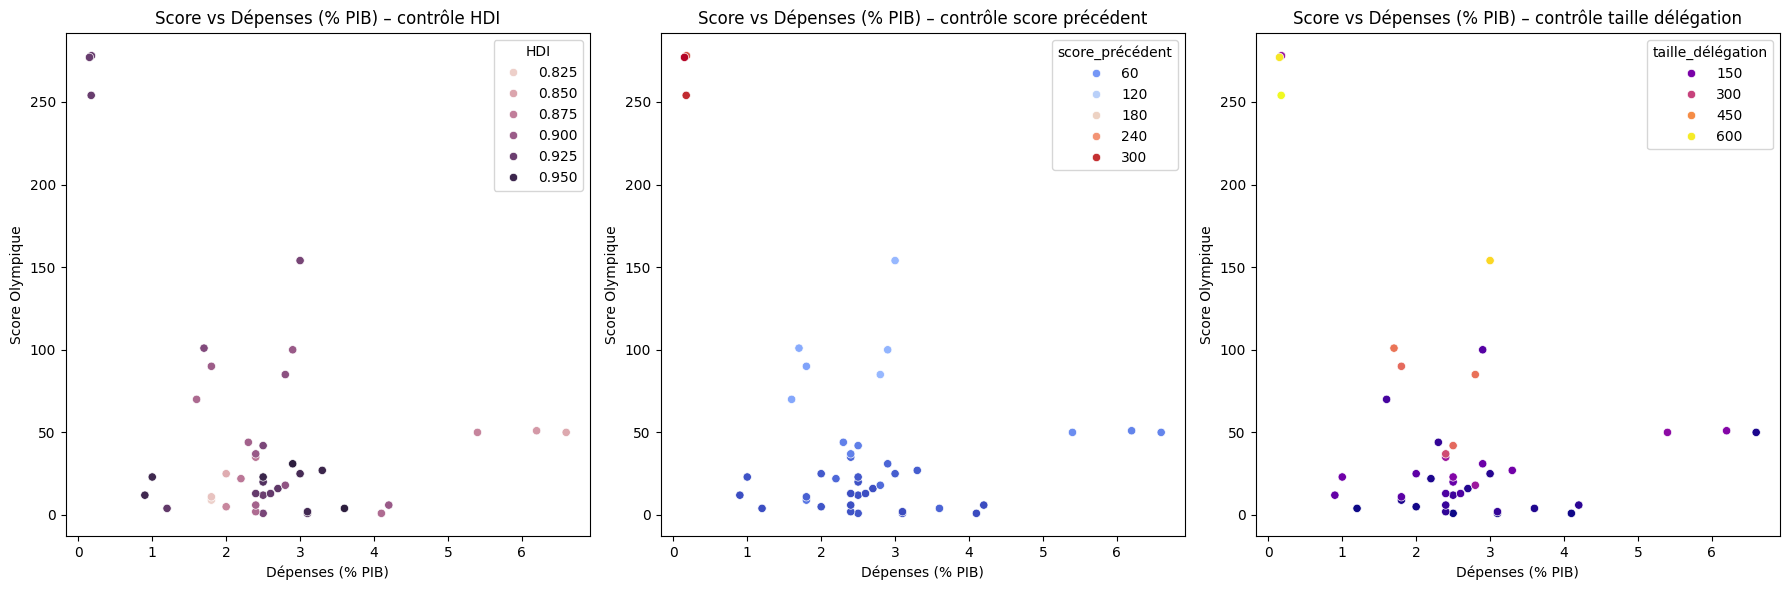

In [32]:
scatter_controls(df_Reg)

### Analyse graphique avec variables de contrôle

Les graphiques ci-dessus représentent la relation entre le score olympique et les dépenses sportives exprimées en pourcentage du PIB, en contrôlant successivement pour différentes variables susceptibles d’influencer la performance olympique.

Le premier graphique met en évidence le rôle du niveau de développement humain (IDH). À niveau de dépenses comparable, les pays présentant un IDH plus élevé tendent à obtenir de meilleurs scores olympiques, ce qui suggère que le capital humain joue un rôle important dans la performance sportive.

Le second graphique contrôle pour le score olympique précédent. On observe une forte persistance de la performance : les pays ayant obtenu de bons résultats lors des Jeux précédents tendent à rester performants, indépendamment de leur effort de dépenses sportives relatif.

Enfin, le troisième graphique contrôle pour la taille de la délégation olympique. Les pays envoyant des délégations plus importantes obtiennent mécaniquement des scores plus élevés, ce qui reflète à la fois une capacité organisationnelle et une profondeur du vivier sportif.

Ces visualisations suggèrent que la relation entre dépenses sportives et performance olympique est fortement médiée par d’autres facteurs structurels, justifiant le recours à une analyse économétrique multivariée.

### Estimation économétrique : modèle multivarié

On estime maintenant un modèle de régression linéaire afin de quantifier la relation entre la performance olympique et les dépenses sportives, en contrôlant simultanément pour plusieurs déterminants clés.

La spécification inclut :
- les dépenses sportives en pourcentage du PIB,
- le niveau de développement humain (IDH),
- le score olympique précédent, afin de capter la dynamique de performance,
- la taille de la délégation, qui reflète l’ampleur de la participation sportive.

L’estimation est menée sur l’édition 2016 des Jeux Olympiques afin de travailler sur une coupe transversale homogène et de limiter les effets de changements structurels dans le temps.

In [33]:
df1 = df_Reg[df_Reg["Year"] == 2016]
model = run_ols(df1, ['Dépenses', 'HDI', 'score_précédent', 'taille_délégation'])
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     247.0
Date:                Mon, 29 Dec 2025   Prob (F-statistic):           6.01e-10
Time:                        23:58:28   Log-Likelihood:                -50.298
No. Observations:                  15   AIC:                             110.6
Df Residuals:                      10   BIC:                             114.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -23.1252     58.89

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


### Interprétation des résultats économétriques (JO 2016)

Interprétation : Le modèle prédit qu'une hausse, à hauteur d'un point de pourcentage du PIB, des dépenses en sport, permettrait une amélioration de 3,41 points environ du score olympique, coefficient significatif à 10%, avec très peu de données mais un R-squared très proche de 1 et des coefficients de "score_précédent" et "taille_délégation" très significatifs.

Le modèle estimé explique une part très importante de la variance du score olympique, avec un R² élevé. Ce résultat reflète principalement la forte persistance de la performance olympique et le rôle de variables structurelles telles que la taille de la délégation.

Le coefficient associé aux dépenses sportives exprimées en pourcentage du PIB est positif mais seulement marginalement significatif. Cela suggère qu’un effort budgétaire plus important est associé à une meilleure performance, mais que cet effet reste limité une fois les autres déterminants pris en compte.

Le niveau de développement humain (IDH) n’apparaît pas significatif dans cette spécification. Ce résultat peut s’expliquer par une faible variabilité de l’IDH au sein de l’échantillon considéré, ainsi que par sa corrélation avec d’autres variables explicatives.

Le score olympique précédent est fortement significatif et présente un coefficient positif élevé. Ce résultat met en évidence une forte inertie de la performance sportive : les pays performants lors d’une édition des Jeux Olympiques ont une probabilité plus élevée de rester performants lors de l’édition suivante.

La taille de la délégation apparaît également comme un déterminant significatif de la performance olympique. Ce résultat est cohérent avec l’idée qu’un nombre plus important d’athlètes augmente mécaniquement les opportunités de médailles.

Enfin, le condition number élevé suggère la présence potentielle de multicolinéarité entre certaines variables explicatives. Les résultats doivent donc être interprétés avec prudence et sont avant tout indicatifs de relations conditionnelles plutôt que d’effets causaux stricts.

In [11]:
print("=== OLS avec USA ===")
model_full = run_ols(df_Reg, ['Dépenses', 'HDI', 'score_précédent', 'taille_délégation'])
print(model_full.summary())

print("\n=== OLS sans USA ===")
df_no_usa = df_Reg[df_Reg['Country'] != 'United States']
model_no_usa = run_ols(df_no_usa, ['Dépenses', 'HDI', 'score_précédent', 'taille_délégation'])
print(model_no_usa.summary())

=== OLS avec USA ===
                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     242.7
Date:                Tue, 30 Dec 2025   Prob (F-statistic):           5.29e-26
Time:                        02:53:47   Log-Likelihood:                -168.34
No. Observations:                  42   AIC:                             346.7
Df Residuals:                      37   BIC:                             355.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const            

### Sensibilité des résultats à la présence des États-Unis

Afin d’évaluer la robustesse des résultats, les estimations sont réalisées une première fois sur l’échantillon complet (avec les jeux de 2016, 2021 et 2024), puis après exclusion des États-Unis.

Les États-Unis constituent une observation atypique en raison de leur taille économique, de l’ampleur de leur délégation et de leur performance olympique historiquement élevée. Leur présence est donc susceptible d’influencer de manière disproportionnée les résultats.

Les estimations montrent que la significativité et le signe des coefficients associés au score précédent et à la taille de la délégation restent globalement stables après exclusion des États-Unis. Cela confirme le rôle central de la dynamique de performance et de la capacité de participation dans la réussite olympique.

En revanche, le coefficient des dépenses sportives en pourcentage du PIB demeure non significatif dans les deux spécifications, suggérant que l’effort relatif de dépenses n’est pas un déterminant robuste de la performance olympique une fois les autres facteurs pris en compte.

Ces résultats indiquent que les conclusions principales ne reposent pas uniquement sur la présence d’un pays dominant et sont globalement robustes à l’exclusion des États-Unis.

Interprétation : Le modèle avec les Etats-Unis prédit qu'une hausse, à hauteur d'un point de pourcentage du PIB, des dépenses en sport, permettrait une amélioration de 1,78 points environ du score olympique, mais le coefficient est non-significatif.

In [35]:
res = train_test_validation(df_Reg[df_Reg['Country'] != 'United States'],
                            ['Dépenses', 'PIB_mean', 'score_précédent', 'taille_délégation'])

print("Validation train-test sur l'échantillon sans USA :")
print(f"R² = {res['R2']:.3f}, MSE = {res['MSE']:.3f}")
print(f"Coefficient de Dépenses estimé : {res['coef_depenses']:.3f}")

Validation train-test sur l'échantillon sans USA :
R² = 0.849, MSE = 337.776
Coefficient de Dépenses estimé : 0.954


### Validation train–test sur l’échantillon sans États-Unis

Cette étape met en œuvre une validation train–test afin d’évaluer la capacité du modèle à prédire la performance olympique hors de l’échantillon utilisé pour l’estimation.

L’analyse est conduite sur l’échantillon excluant les États-Unis afin d’éviter que les résultats ne soient dominés par une observation atypique. Le modèle est estimé sur un sous-ensemble des données, puis testé sur des observations non utilisées lors de l’estimation.

Les indicateurs reportés sont le coefficient de détermination (R²) et l’erreur quadratique moyenne (MSE), qui permettent d’évaluer respectivement le pouvoir explicatif et la précision prédictive du modèle sur l’échantillon de test.

Le coefficient estimé associé aux dépenses sportives est également reporté à titre indicatif, afin d’examiner la stabilité de son ordre de grandeur dans un cadre prédictif.

Interprétation : Le modèle prédit qu'une hausse à hauteur d'un point de pourcentage du PIB des dépenses en sport permettrait une amélioration de 0,954 points environ du score olympique, avec une MSE égale à 337 ce qui est plutôt convenable, et un R-squared égal à 0,849 assez moyen.


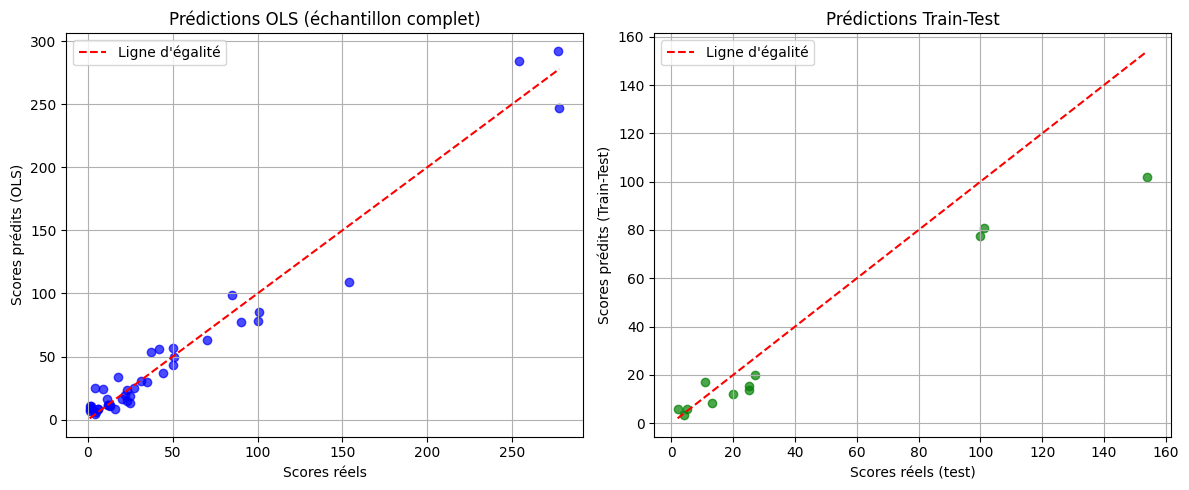

In [36]:
plot_regression_results(
    y_full = df_Reg['Score'],
    fitted_full = model_full.fittedvalues,
    y_test = res['y_test'],
    y_pred = res['y_pred']
)

### Lecture des résultats de prédiction

Le graphique de gauche compare les scores olympiques observés aux scores ajustés par le modèle OLS sur l’échantillon complet. La proximité de la majorité des points avec la ligne d’égalité indique un bon ajustement in-sample, en cohérence avec le coefficient de détermination élevé obtenu précédemment.

Le graphique de droite présente les prédictions issues de la procédure train–test sur l’échantillon de test. Comme attendu, la dispersion autour de la ligne d’égalité est plus importante que dans le cas in-sample, reflétant la perte naturelle de précision lorsque le modèle est appliqué à des données non utilisées lors de l’estimation.

Ces graphiques illustrent que le modèle capture correctement les grandes variations de la performance olympique, tout en mettant en évidence les limites de la prédiction individuelle, en particulier pour les pays aux performances extrêmes.

### Estimation par variables instrumentales (2SLS)

Cette section vise à traiter un possible problème d’endogénéité des dépenses sportives. En particulier, les dépenses peuvent être corrélées à des déterminants non observés de la performance olympique, ce qui biaiserait les estimations obtenues par MCO.

Pour répondre à cette problématique, une estimation en deux étapes (2SLS) est mise en œuvre. Les dépenses sportives sont instrumentées par leurs valeurs retardées, supposées corrélées aux dépenses actuelles mais exogènes à la performance olympique contemporaine conditionnellement aux autres variables de contrôle.

La première étape consiste à expliquer les dépenses sportives par leur valeur retardée et les variables de contrôle. La seconde étape utilise les dépenses prédites issues de cette première étape pour estimer leur impact sur le score olympique.

Les résultats des deux étapes sont reportés ci-dessous, ainsi qu’une comparaison du coefficient associé aux dépenses sportives entre l’estimation OLS et l’estimation 2SLS.

Ces résultats étant non-significatifs pour les dépenses, nous n'en tirerons pas d'enseignement quant à la réponse à notre problème initial. Au vu du faible nombre de lignes de données, il n'est pas surprenant de ne pas obtenir d'effet causal significatif des dépenses en sport.

In [12]:
# On ajoute les dépenses passées
df2sls = add_lagged_depenses(df_Reg.copy())

# Double MCO
first_stage, second_stage = run_2sls(df2sls)


print("\nPremière étape 2SLS :")
print(first_stage.summary())

print("\nDeuxième étape 2SLS :")
print(second_stage.summary())

# Comparaison avec OLS
print(f"\nComparaison : Coef Dépenses OLS = {model_full.params['Dépenses']:.3f}, 2SLS = {second_stage.params['Depenses_hat']:.3f}")


⚠ 15 lignes n'ont pas de Depenses_lag et seront ignorées.

Première étape 2SLS :
                            OLS Regression Results                            
Dep. Variable:               Dépenses   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     227.5
Date:                Tue, 30 Dec 2025   Prob (F-statistic):           1.49e-17
Time:                        02:53:50   Log-Likelihood:                 5.5982
No. Observations:                  27   AIC:                            -1.196
Df Residuals:                      22   BIC:                             5.283
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

### Analyse des dépenses sportives en volume

Dans cette section, les dépenses sportives exprimées en pourcentage du PIB sont converties en dépenses en volume, en les rapportant au niveau du PIB de chaque pays. Cette transformation permet de mieux tenir compte des différences de taille économique entre pays et d’examiner si le niveau absolu des ressources consacrées au sport est plus informatif que l’effort relatif.

Le jeu de données est préparé de manière à inclure uniquement les observations pour lesquelles l’ensemble des variables nécessaires est disponible. Un aperçu des premières lignes est présenté afin de vérifier la cohérence des ordres de grandeur.

Le graphique ci-dessous représente la relation brute entre le score olympique et les dépenses sportives en volume. Il permet une première lecture descriptive de l’association entre les moyens financiers mobilisés et la performance observée, avant toute analyse économétrique supplémentaire.

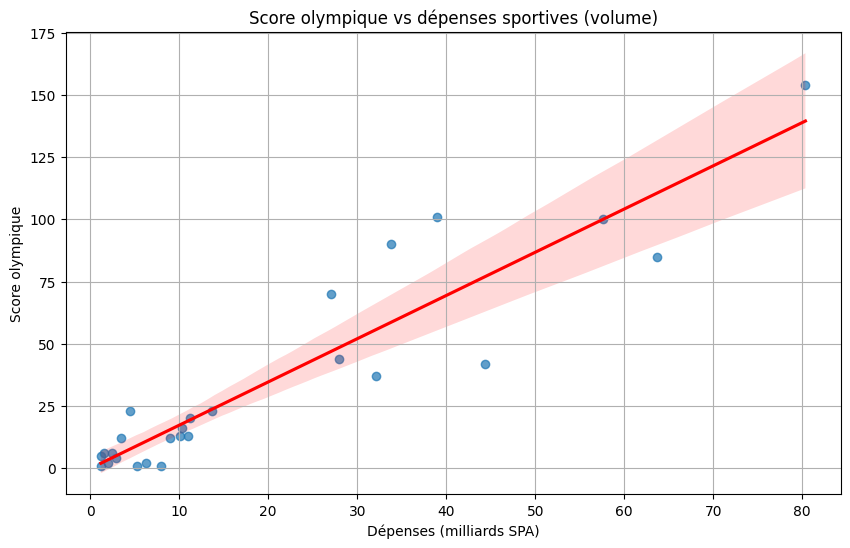

In [38]:
df = prepare_data_volume(
    df_merged_final2,
    df_PIB_long
)
plot_score_vs_spending(
    df,   
)

Le graphique met en évidence une relation positive entre le score olympique et le niveau des dépenses sportives exprimées en volume. Les pays qui consacrent des montants plus élevés en valeur absolue au sport tendent, en moyenne, à obtenir de meilleures performances aux Jeux olympiques.

Cette relation apparaît plus nette que lorsque les dépenses sont mesurées en pourcentage du PIB, ce qui suggère que la taille économique joue un rôle important dans la capacité d’un pays à transformer ses ressources financières en résultats sportifs. Les pays disposant d’un PIB élevé peuvent mobiliser des moyens substantiels même pour un effort relatif modéré.

Néanmoins, la dispersion des points reste importante, en particulier pour des niveaux intermédiaires de dépenses. À montant donné, les performances observées varient sensiblement d’un pays à l’autre, indiquant que les dépenses en volume ne suffisent pas à expliquer à elles seules la réussite olympique.

Ce constat justifie le recours à des modèles économétriques intégrant d’autres déterminants structurels, ainsi qu’à des stratégies visant à traiter les problèmes potentiels d’endogénéité entre dépenses et performance.

In [39]:
X = df[['Dépenses_volume']]
X = sm.add_constant(X)
y = df['Score']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     150.0
Date:                Mon, 29 Dec 2025   Prob (F-statistic):           8.20e-12
Time:                        23:58:28   Log-Likelihood:                -107.08
No. Observations:                  26   AIC:                             218.2
Df Residuals:                      24   BIC:                             220.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0941      4.117     

Interprétation : Le modèle prédit qu'une hausse de 1 milliard de SPA (Standard de Pouvoir d'Achat) des dépenses en sport permettrait une amélioration de 1,7 points environ du score olympique, coefficient significatif à 0% mais avec un intercept non-significatif et assez peu de données.

Cette régression estime la relation bivariée entre le score olympique et les dépenses sportives mesurées en volume, sans introduire de variables de contrôle supplémentaires.

Le coefficient associé aux dépenses sportives en volume est positif et fortement significatif. Il suggère qu’une augmentation des ressources financières mobilisées pour le sport est associée, en moyenne, à une hausse du score olympique. La magnitude du coefficient indique un effet économiquement non négligeable dans cette spécification simple.

Le pouvoir explicatif du modèle est élevé (R² ≈ 0,86), ce qui reflète la forte corrélation observée graphiquement entre ces deux variables. Toutefois, ce résultat doit être interprété avec prudence : l’absence de contrôles implique que le coefficient capte également l’effet de facteurs corrélés aux dépenses, tels que la taille économique, le niveau de développement ou la tradition sportive des pays.

Cette estimation constitue donc un point de départ descriptif. Elle motive l’introduction, dans les sections suivantes, de variables de contrôle et de stratégies économétriques plus élaborées afin d’isoler le rôle propre des dépenses sportives dans la performance olympique.

### Introduction d’une dimension dynamique

Les performances olympiques présentent une forte inertie dans le temps : les pays qui obtiennent de bons résultats lors d’une édition tendent à conserver un avantage lors des Jeux suivants. Cette persistance peut refléter des effets d’apprentissage, la stabilité des infrastructures sportives, ainsi que l’accumulation de capital humain spécifique au sport de haut niveau.

Afin de tenir compte de cette dynamique, on estime ici un modèle enrichi incluant le score olympique de l’édition précédente comme variable explicative. Cette approche permet de distinguer l’effet propre des dépenses sportives contemporaines de la continuité des performances passées.

L’analyse repose sur une base de données mise sous forme « long », reliant chaque édition des Jeux à la précédente, ce qui permet d’exploiter l’information temporelle tout en conservant une structure comparable aux estimations précédentes.

In [40]:
df_previous = df_Reg
df_long = prepare_data_long(df, df_previous)

# Sélection des colonnes utilisées et suppression des NaN
df_long_simple = df_long[['Score', 'Dépenses_volume', 'score_précédent']].dropna()

# Préparer X et y
X = df_long_simple[['Dépenses_volume', 'score_précédent']]
X = sm.add_constant(X)  # ajoute l'intercept
y = df_long_simple['Score']

# Ajuster le modèle OLS
model_long = sm.OLS(y, X).fit()

# Afficher le résumé
print(model_long.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     127.6
Date:                Mon, 29 Dec 2025   Prob (F-statistic):           3.56e-13
Time:                        23:58:28   Log-Likelihood:                -100.43
No. Observations:                  26   AIC:                             206.9
Df Residuals:                      23   BIC:                             210.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5574      3.278     

Interprétation : Le modèle prédit qu'une hausse de 1 milliard de SPA (Standard de Pouvoir d'Achat) des dépenses en sport permettrait une amélioration de 0,66 points environ du score olympique, coefficient significatif à 5%.

Les résultats confirment l’existence d’une forte persistance des performances olympiques. Le score de l’édition précédente apparaît comme un déterminant majeur et statistiquement significatif du score courant, ce qui souligne le caractère cumulatif de la réussite sportive au niveau international.

Une fois cette dimension dynamique intégrée, l’effet des dépenses sportives en volume demeure positif mais devient plus modéré. Ce résultat suggère que les dépenses contribuent davantage à consolider des performances déjà élevées qu’à générer, à elles seules, un saut de performance.

Le bon niveau d’ajustement du modèle indique que la combinaison des facteurs dynamiques et financiers permet de rendre compte d’une large part des écarts observés entre pays. Ces résultats mettent en évidence le rôle central de la trajectoire de long terme dans la réussite olympique, les dépenses sportives jouant un rôle complémentaire plutôt que déterminant isolé.

## Conclusion

Ce projet propose une analyse empirique de l'importance des politiques d'investissement public en sport pour améliorer les performances nationales aux Jeux Olympiques, en mobilisant des données économiques, sociales et sportives pour un ensemble de pays européens et les États-Unis. À travers une progression méthodologique structurée, l’étude met en évidence les mécanismes associés à la performance internationale aux Jeux Olympiques.

Les résultats montrent que la réussite olympique repose largement sur une dynamique de long terme. Le score obtenu lors des éditions précédentes apparaît comme un déterminant central des performances futures, reflétant des effets de persistance liés à l’expérience, aux infrastructures sportives et à l’organisation des systèmes de haut niveau. La taille des délégations joue également un rôle significatif, soulignant l’importance de la capacité de participation dans l’accumulation de médailles.

En revanche, l’impact des dépenses sportives, mesurées en proportion du PIB ou en volume, s’avère plus nuancé. Si une relation positive est observée dans certaines spécifications simples (par exemple dans le cas des JO de 2016), cet effet devient moins robuste une fois les autres facteurs pris en compte. Les analyses suggèrent ainsi que les dépenses contribuent davantage à soutenir des performances existantes qu’à expliquer, à elles seules, les écarts de réussite entre pays.
Cela dit, nous avons montré que le coefficient associé aux dépenses est beaucoup plus significatif lorsqu'on l'étudie sous forme de volume, ce qui nous permet de prédire avec confiance un impact positif et non-négligeable des investissements publics en sport sur le nombre de médailles glanées aux Jeux Olympiques.

Dans l’ensemble, ce travail met en lumière le caractère multifactoriel et cumulatif de la performance olympique. L’approche retenue, volontairement parcimonieuse, constitue une première étape vers des analyses plus approfondies. Des extensions futures pourraient intégrer des méthodes économétriques plus sophistiquées, des données plus fines sur les politiques sportives (qui capteraient seulement les dépenses en sport, pas en loisir et pour les cultes) ou encore des effets institutionnels afin d’approfondir la compréhension des politiques publiques expansionnistes dans le domaine sportif et leur impact sur la formation et le niveau des plus grands sportifs d'un pays.